In [13]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [177]:
from quantum_tools.contexts.quantum_caller import *
from quantum_tools.statistics import *
from quantum_tools.examples.symbolic_contexts import *
from quantum_tools.examples.prob_dists import *
from quantum_tools.rmt.unitary_param import *
from quantum_tools.utilities import utils
from quantum_tools.statistics.probability import *
from quantum_tools.config import *
from quantum_tools.inflation import marginal_equality
from itertools import permutations
import numpy as np
from scipy import optimize
from quantum_tools.visualization.triangle_plot import *

In [3]:
rvc = RandomVariableCollection.new(('A', 'B', 'C'), (4, 4, 4))
triangle_permutation = utils.get_triangle_permutation(2)
symbolic_context = ABC_444_444
preinjectable_sets = symbolic_context.preinjectable_sets
symbolic_context = SymbolicContext(preinjectable_sets, symbolic_context.outcomes)
infl_rvc = RandomVariableCollection.new(
    names=marginal_equality.rv_names_from_sc(preinjectable_sets),
    outcomes=symbolic_context.outcomes
)

In [168]:
result_backlog = []

def minimize_callback(f):
    logged_results = []
    result_backlog.append(logged_results)
    def _callback(x):
        result = f(x)
#         print(result)
        print(result)
        logged_results.append(result)
    return _callback

def stochastic_jump(x, scale_std=0.001):
    norm_x = np.linalg.norm(x)
    delta_x = np.random.normal(0.0, norm_x * scale_std, x.shape)
    return x + delta_x

In [189]:
def w_to_target(w):
    def _w_to_target(pd):
        b = marginal_equality.contexts_marginals(pd, preinjectable_sets)
        return np.sum(w * b)
    return _w_to_target

def w_to_target_sym(w):
    def _w_to_target(pd):
        b = marginal_equality.contexts_marginals(pd, preinjectable_sets)
        return np.sum(w * symmetrizingmatrix.dot(b))
    return _w_to_target

def pd_matching(pd_target):
    def _pd_matching(pd):
        return ProbDist.distance(pd, pd_target)
    return _pd_matching

In [136]:
w_to_target(gurobicertnosymmetry)(fritz(rvc))

-0.12852182413150268

In [190]:
qc = QuantumCaller(None, rvc, triangle_permutation)
qc_ineq = QuantumCaller(w_to_target(mosekcertnosymmetry),rvc,triangle_permutation)
qc_match = QuantumCaller(pd_matching(epqpd),rvc,triangle_permutation)
qc_ineq_sym = QuantumCaller(w_to_target_sym(binarycert),rvc,triangle_permutation)

In [179]:
def exchange_parties(pd):
    support = pd._support
    summed_support = np.zeros(support.shape)
    for i in permutations(range(3)):
        summed_support += support.transpose(i)
    summed_support /= np.sum(summed_support)
    return ProbDist(pd._rvc, summed_support)

In [120]:
PROFILE_MIXIN(stress_test)

         499133 function calls (495785 primitive calls) in 0.927 seconds

   Ordered by: cumulative time
   List reduced from 150 to 30 due to restriction <0.2>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001    0.932    0.932 <ipython-input-95-b4cbeb715d96>:1(stress_test)
       93    0.002    0.000    0.929    0.010 /cygdrive/t/OneDrive/quantum_tools/code/quantum_tools/contexts/quantum_caller.py:16(__call__)
       93    0.000    0.000    0.612    0.007 /cygdrive/t/OneDrive/quantum_tools/code/quantum_tools/contexts/quantum_caller.py:58(_call)
       93    0.004    0.000    0.611    0.007 <ipython-input-79-8f2a9bf15c01>:2(_w_to_target)
       93    0.001    0.000    0.606    0.007 /cygdrive/t/OneDrive/quantum_tools/code/quantum_tools/inflation/marginal_equality.py:53(contexts_marginals)
       93    0.000    0.000    0.593    0.006 /usr/lib/python3.4/site-packages/numpy/core/shape_base.py:232(hstack)
       93    0.002    0.000    0

In [95]:
def stress_test():
    for i in range(93):
        qc(np.random.normal(0,1,qc.size))

In [191]:
res = optimize.minimize(qc_ineq_sym, stochastic_jump(fritz_param, 0.01), tol=0.00001, callback=minimize_callback(qc_ineq_sym))

0.192728135876
0.107709840537
0.06762524818
0.0143870914854
-0.00571492059801
-0.0103183082502
-0.0167741814385
-0.0222592677189
-0.0245545592796
-0.0253315625786
-0.0256975639287
-0.0258567842993
-0.0260478905921
-0.02614817383
-0.0263050549124
-0.0264018206276
-0.0265334704852
-0.0265978215886
-0.0266567163119
-0.026703285577
-0.0267245318983
-0.0267550932199
-0.0267684416943
-0.0267904889683
-0.0268234706393
-0.0268387097672
-0.0268580262774
-0.0268653857823
-0.0268672714628
-0.0268700593486
-0.0268732317779
-0.0268748591131
-0.0268760683218
-0.026877727505
-0.0268804196474
-0.0268846853103
-0.026889855658
-0.0268917292456
-0.0268920918241
-0.0268922430184
-0.026892453667
-0.0268926933152
-0.0268930459144
-0.0268933315335
-0.0268934434999
-0.0268934734213
-0.0268934883787
-0.0268935135512
-0.0268935557906
-0.0268936202113
-0.0268936744323
-0.0268936963853
-0.0268937079261
-0.0268937164053
-0.0268937313321
-0.0268937581306
-0.0268938054392
-0.0268938834887
-0.0268939884041
-0.0268940

In [187]:
res = optimize.minimize(qc_ineq, res['x'], tol=0.00001, callback=minimize_callback(qc_ineq))

1.00481374432
0.69844313923
0.295498729604
0.155561253143
0.0864710631762
0.0321600475895
0.00365084578434
0.00096026522037
0.000588947239192
0.000300481144246
9.36198853757e-05
2.93767283507e-05
8.21683889457e-06
5.86815813262e-06
4.64237322037e-06
3.1686807837e-06
2.44191159315e-06
2.05062348734e-06
1.77055393624e-06
1.53425837295e-06
1.39867533869e-06
1.3233570106e-06
1.26117659942e-06
1.20220760787e-06
1.15519098855e-06
1.10932013145e-06
1.04147743425e-06
9.37724911738e-07
8.1689718936e-07
7.41576413953e-07
7.07711676252e-07
6.8147266515e-07
6.40362474685e-07
5.82865939575e-07
5.42851855246e-07
5.26943789208e-07
5.21576879013e-07
5.14303931098e-07
5.01547201759e-07
4.78523241901e-07
4.37216511989e-07
3.66177431083e-07
2.57899399753e-07
1.68779174124e-07
1.25558717729e-07
1.02776494078e-07
9.27157529393e-08
8.12948794854e-08
6.34441109663e-08
3.71344542332e-08
1.54035672474e-08
7.38478201487e-09
6.06022488173e-09
5.71960743265e-09


In [182]:
epqpd = exchange_parties(qc_ineq.context(res['x']))

<IPython.core.display.Javascript object>


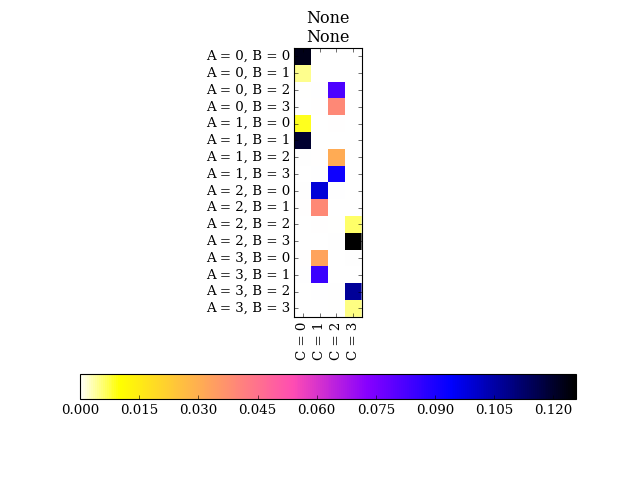

In [192]:
triangle_plot(qc.context(res['x']))

In [163]:
np.savetxt(utils.temp_dir('fritz_param.csv'), _149['x'])

In [165]:
fritz_param

array([-1.12567,  0.96627,  1.56713,  1.76249,  1.16189,  0.76526,  1.56497, -1.56695,  0.05863, -0.71063, -2.01935,
        0.43202,  0.45003, -0.66787,  0.13397, -1.08581,  0.61554,  1.56099, -0.00353, -1.65544, -0.40615, -0.10798,
       -0.41347, -1.56033, -0.0182 , -0.32451,  0.8188 ,  1.13371,  1.32347, -0.23141,  0.26575, -0.23823, -0.97122,
        1.57037,  0.00009,  3.13392, -0.75365,  0.64139,  0.00734,  0.00017, -0.05015,  0.79757, -1.30264, -1.57091,
       -0.12828, -0.39462,  1.09207,  0.66811,  1.57092,  1.57029, -0.00004, -1.1764 , -1.55913, -0.24125, -0.76183,
       -0.81927, -0.18881, -0.83368,  0.10814,  0.76305,  0.79116, -1.27076,  1.56665,  0.78536, -1.57086, -0.00011,
       -0.75924, -1.56413,  1.17029,  0.78736,  0.7444 , -0.00173,  0.29555, -0.00476, -0.37073, -3.25012, -1.72745,
        0.00612,  0.92594, -0.00003, -1.20822, -0.00067, -0.00007, -2.15971,  0.00025, -0.31415, -0.76161,  0.05069,
       -0.7854 , -2.02306,  1.57081,  2.07181, -0.34087])

In [164]:
fritz_param = np.loadtxt(utils.temp_dir('fritz_param.csv'))

In [188]:
mosekcert = np.loadtxt(utils.temp_dir('mosekcert.csv'))
gurobicert = np.loadtxt(utils.temp_dir('gurobicert.csv'))
symmetrizingmatrix = np.loadtxt(utils.temp_dir('symmetrizingmatrix.csv'), delimiter=',')
gurobicertnosymmetry = np.loadtxt(utils.temp_dir('gurobicertnosymmetry.csv'))
mosekcertnosymmetry = np.loadtxt(utils.temp_dir('mosekcertnosymmetry.csv'))
binarycert = np.loadtxt(utils.temp_dir('binarycert.csv'))

In [197]:
np.sum(symmetrizingmatrix[np.where(mosekcert != 0)], axis=1)

array([ 24.,  48.,  48.,  24.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,  24.,  48.,  48.,  48.,  24.,  24.,  48.,  48.,
        48.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,
        48.,  48.,  48.,  48.,  48.,  24.,  24.,  24.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,  24.,  48.,  24.,  48.,
        48.,  48.,  48.,  48.,  48.,  48.,  48.,  24.,  48.,  48.,  48.,  48.,  24.,  48.,  24.,  48.,  48.,  48.,  48.,
        48.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,  24.,  48.,  48.,  48.,  24.,  48.,  48.,  24.,  48.,  24.,  24.,
        48.,  48.,  48.,  48.,  48.,  24.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,
        48.,  48.,  24.,  24.,  48.,  48.,  48.,  48.,  48.,  24.,  24.,  48.,  48.,  24.,  48.,  24.])